In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [476]:
mouse = '4139265.5'
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

df_mouse = df[df['MouseName'].str.match(mouse)]
# df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1410,4139265.5,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1412,4139265.5,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.5\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\10_02_2...
1439,4139265.5,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.5\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\12_02_2...
1462,4139265.5,15_02_2019,2,TwoTower_foraging,86,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.5\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\15_02_2...
1481,4139265.5,17_02_2019,2,TwoTower_foraging,80,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.5\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\17_02_2...
1501,4139265.5,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.5\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\19_02_2...
1519,4139265.5,21_02_2019,2,TwoTower_foraging,105,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.5\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\21_02_2...
1528,4139265.5,22_02_2019,2,TwoTower_foraging,98,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.5\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\22_02_2...
1534,4139265.5,23_02_2019,2,TwoTower_foraging,96,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.5\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\23_02_2...
1539,4139265.5,24_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.5\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.5\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.5\24_02_2...


In [477]:
sess = df_mouse.iloc[2]
print(sess['data file'])

G:\My Drive\VR_Data\TwoTower\4139265.5\12_02_2019\TwoTower_foraging_2.sqlite


In [478]:
VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


num aberrant ttls 0.0
(19948,) (19948, 21) 65960
frame diff 0


In [479]:
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=20,speed=VRDat.speed._values)
S_trial_mat[np.isnan(S_trial_mat)]=0


In [480]:
print(S.shape)

(19948, 1386)


In [527]:
effMorph = trial_info['morphs'] +  trial_info['wallJitter']
msort = np.argsort(effMorph)


In [444]:
masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True)

start bootstrap


KeyboardInterrupt: 

In [262]:
pc_mask = masks[0] | masks[1]

In [482]:
S_pc = S_trial_mat[:,:,:] #pc_mask]
nanmask = 1-np.isnan(S_pc)

In [501]:
S_tmat = sp.stats.zscore(np.reshape(S_pc,[S_trial_mat.shape[0],-1]),axis=-1)
nanmask = np.reshape(nanmask,[S_trial_mat.shape[0],-1])

In [502]:
S_t_rmat = np.matmul(S_tmat,S_tmat.T)/np.matmul(nanmask,nanmask.T)

In [503]:
print(S_t_rmat.shape)

(90, 90)


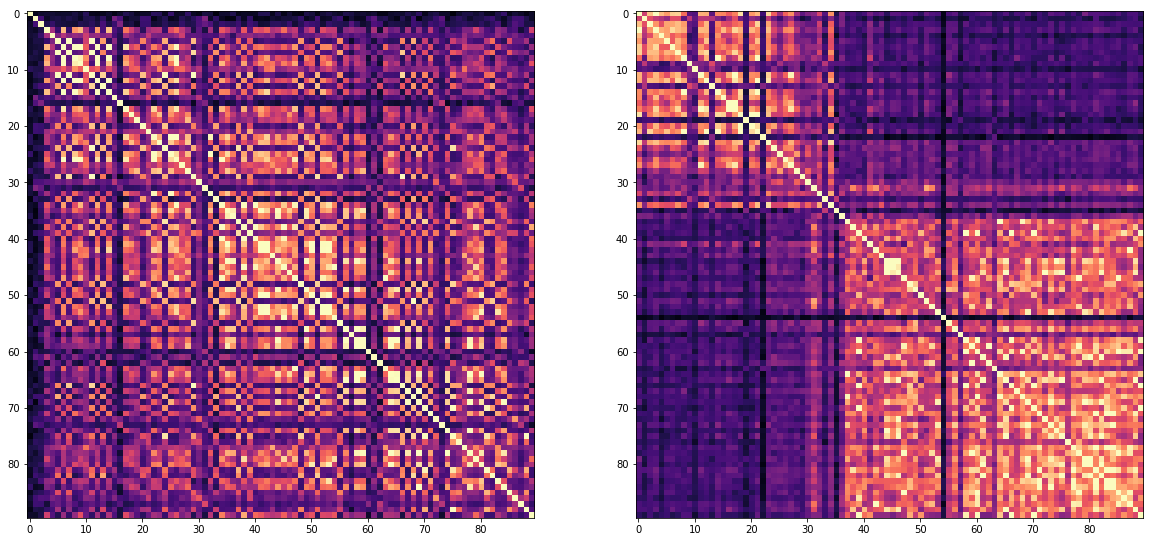

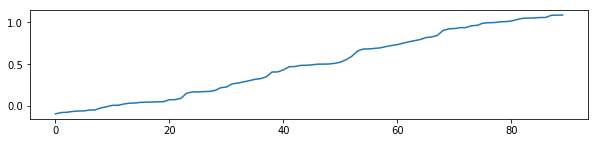

In [507]:
f,ax = plt.subplots(1,2,figsize=[20,10],sharex=True)
ax[0].imshow(S_t_rmat,cmap='magma',vmin=0,vmax=.3)
S_rmat_sort = S_t_rmat[msort,:]
S_rmat_sort = S_rmat_sort[:,msort]
ax[1].imshow(S_rmat_sort,cmap='magma',vmin=0,vmax=.3)
f,ax = plt.subplots(figsize=[10,2])
ax.plot(effMorph[msort])

In [499]:
import sklearn as sk
import sklearn.cluster as clust


In [514]:
aggclust = clust.AgglomerativeClustering(n_clusters=5,affinity='cosine',linkage="average")
aggclust.fit(S_tmat)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=5, pooling_func='deprecated')

In [515]:
print(aggclust.labels_)

[3 4 0 1 1 2 1 2 1 1 1 2 1 2 1 2 0 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 1 2 1 1 1
 2 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2 1 2 1 1 1 2 1 2 1 2 1 2 0
 1 2 2 1 1 1 1 2 2 1 1 2 2 2 2 1]


In [516]:
clustsort = np.argsort(aggclust.labels_)

In [517]:
print(effMorph[clustsort])

[ 0.28706602  0.31802364  0.05067847  1.01760379  0.76748687  1.03500024
  0.99837707  0.93692493  1.00975593  0.92216616  1.08488291  0.68889957
  0.72367414  0.55330093  1.05142751  1.05341332  0.50009452  0.69497891
  1.04976043  0.78124975  1.0069084   0.47149156  0.81880265  0.7520733
  0.9649705   0.48707641  0.43147321  0.93839195  0.26386164  0.49972714
  0.5943322   1.08734031  0.40582497  0.49138795  0.99108726  0.65726574
  0.99653178  0.40696116  1.08872702  0.90386271  0.50198983  0.8257056
  1.05954754  0.79450718  0.7337277   0.32649691  0.84383815  0.48480281
  0.71065031  0.96009989  0.52360474  0.92649899  0.34842215  0.46886859
  1.05856757  0.50956651  0.68284712  0.18428464  0.15082536  0.16711793
  0.0339615  -0.02441438  0.17293637 -0.05002589  0.17092135  0.16730724
 -0.0094719   0.04588944  0.00701162  0.21799148 -0.06714718  0.30189583
 -0.06212863  0.03229116  0.22580403  0.04459459  0.04878987 -0.04806883
  0.07452195 -0.09574568  0.04279221  0.27296752 -0.0

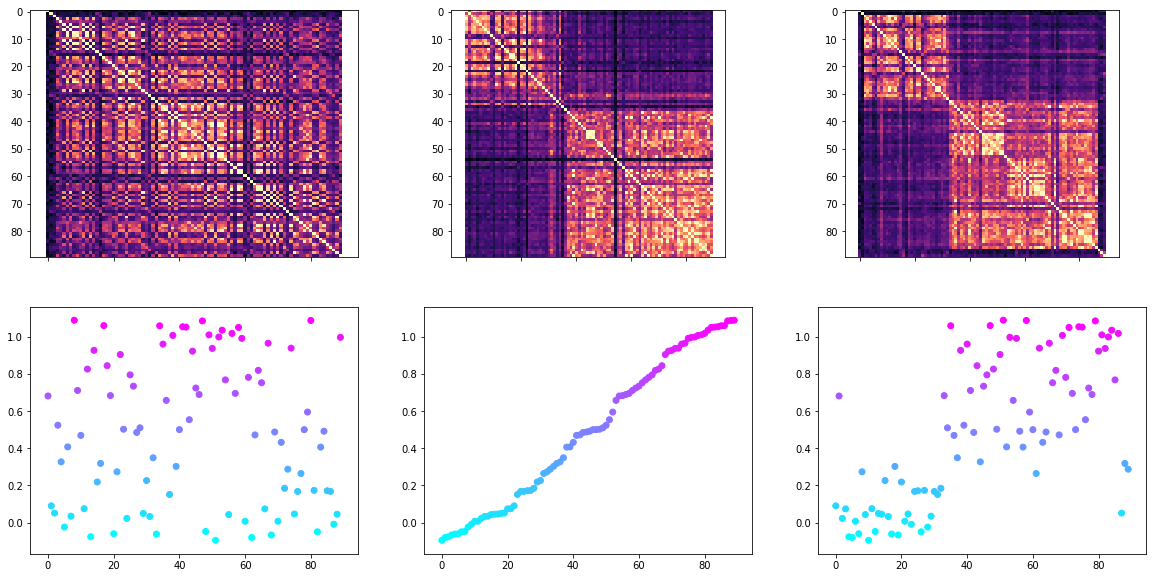

In [530]:
f,ax = plt.subplots(2,3,figsize=[20,10],sharex=True)
ax[0,0].imshow(S_t_rmat,cmap='magma',vmin=0,vmax=.3,aspect='auto')
S_agg_sort = S_t_rmat[clustsort[::-1],:]
S_agg_sort = S_agg_sort[:,clustsort[::-1]]
ax[0,2].imshow(S_agg_sort,cmap='magma',vmin=0,vmax=.3)
ax[0,1].imshow(S_rmat_sort,cmap='magma',vmin=0,vmax=.3)

x=np.arange(effMorph.size)
ax[1,0].scatter(x,effMorph,c=effMorph,cmap='cool')
ax[1,1].scatter(x,effMorph[msort],c=effMorph[msort],cmap='cool')
ax[1,2].scatter(x,effMorph[clustsort[::-1]],c=effMorph[clustsort[::-1]],cmap='cool')

In [533]:
aggclust.children_

array([[ 52,  53],
       [ 64,  80],
       [  7,  11],
       [ 41,  50],
       [  8,  12],
       [ 67,  69],
       [ 70,  75],
       [ 44,  49],
       [ 22,  25],
       [  9,  26],
       [  5,  92],
       [ 14,  94],
       [ 38,  40],
       [  6,  99],
       [ 56,  58],
       [ 51,  68],
       [ 29,  66],
       [ 42,  93],
       [ 45, 102],
       [ 90, 107],
       [ 65, 104],
       [ 32,  98],
       [ 78,  91],
       [ 47,  63],
       [ 59, 112],
       [ 35,  97],
       [101, 103],
       [ 34, 108],
       [ 36, 115],
       [ 81,  96],
       [ 24,  37],
       [ 54,  79],
       [ 82, 105],
       [ 95, 114],
       [110, 123],
       [ 88, 119],
       [100, 106],
       [ 23,  28],
       [ 74, 124],
       [ 39, 120],
       [ 17, 116],
       [ 48, 122],
       [117, 121],
       [ 13, 131],
       [ 84, 128],
       [ 43,  77],
       [ 71,  83],
       [ 46, 118],
       [ 55, 126],
       [ 18, 127],
       [ 20,  33],
       [111, 137],
       [  3,